# Demo of ascending and descending thermals

Thomas Schanzer  
January 2022

In this notebook, we demonstrate the progress made so far on the updraft and downdraft calculations for the convection scheme.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from metpy.units import units
import sys

from dparcel.environment import idealised_sounding
sys.path.append('../convection_scheme')
from thermal_generator import ThermalGenerator

We create a standard idealised sounding and create an instance of `ThermalGenerator`:

In [2]:
env = idealised_sounding(0.5)
pressure = np.flip(env._pressure_raw*units.mbar)
height = np.flip(env._height_raw*units.meter)
temperature = np.flip(env._temperature_raw*units.celsius)
specific_humidity = env.specific_humidity(env.height(pressure))

In [3]:
%%time
generator = ThermalGenerator(pressure, height, temperature, specific_humidity)

CPU times: user 1.61 s, sys: 8.45 ms, total: 1.62 s
Wall time: 1.62 s


Instantiation of `ThermalGenerator` can take up to 1.5 s for high-resolution soundings (this one has 163 levels) but should be faster in a real model scenario.

## Ascending thermals

The `updraft` method of the `ThermalGenerator` object calculates all the relevant properties associated with the updraft, and takes about 0.4 s:

In [4]:
generator.updraft?

Signature:
generator.updraft(
    i_init,
    t_perturb,
    q_perturb,
    l_initial,
    w_initial,
    entrainment_rate,
    dnu_db,
    drag,
    l_crit,
)
Docstring:
Calculate the properties associated with an ascending thermal.

Args:
    i_init: Index of the initiation level.
    t_perturb: Initial temperature perturbation. The initial
        temperature is the environmental value plus t_perturb.
    q_perturb: Initial specific humidity perturbation. The
        inital specific humidity is the environmental value
        plus q_perturb.
    l_initial: Initial liquid water content (mass of liquid
        per unit total mass).
    w_initial: Initial velocity (must be non-negative).
    entrainment_rate: Entrainment rate (should have dimensions
        of 1/length).
    dnu_db: The proportionality constant defining the detrainent
        rate nu. When the buoyancy b is negative, nu is zero,
        and when b > 0, nu = b*dnu_db. The dimensions of dnu_db
        should be time^2/le

In [52]:
def plot_updraft(updraft):
    fig, axes = plt.subplots(1, 5, figsize=(15,5))

    axes[0].plot(updraft.temperature, height, label='Parcel')
    axes[0].plot(temperature, height, label='Environment')
    axes[0].legend()
    axes[0].set(xlabel='Temperature (K)', ylabel='Height (m)')

    axes[1].plot(updraft.specific_humidity*1e3, height, label='Specific humidity')
    axes[1].plot(updraft.liquid_content*1e3, height, '--', color='tab:blue',
                 label='Liquid content')
    axes[1].plot(updraft.precipitation*1e3, height, '-.', color='tab:blue',
                 label='Precipitation')
    axes[1].plot(specific_humidity*1e3, height,
                 label='Environmental\nspecific humidity')
    axes[1].legend()
    axes[1].set(xlabel='Moisture variables (g/kg)', ylabel='')

    axes[2].plot(updraft.buoyancy, height)
    axes[2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')

    axes[3].plot(updraft.m_detrained*1e2, height)
    axes[3].set(xlabel='Percentage of mass detrained', ylabel='')
    axes[3].text(
        0.1, 2100,
        '{:.2f} % detrained in total'.format(np.sum(updraft.m_detrained.m)*1e2))

    axes[4].plot(updraft.velocity, height)
    axes[4].set(xlabel='Velocity (m/s)', ylabel='')
    axes[4].yaxis.tick_right()

    for ax in axes:
        ax.grid()
        ax.set_ylim(-100, 8100)

    for ax in axes[1:-1]:
        ax.set_yticklabels([])

    fig.tight_layout()

In [85]:
%%time
i_init = np.searchsorted(pressure, env.pressure(0*units.km))
t_pert = 5*units.delta_degC
q_pert = 0*units.dimensionless
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.5/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 1e-3*units.dimensionless

updraft = generator.updraft(
    i_init, t_pert, q_pert, l_initial, w_initial, rate, dnu_db, drag, l_crit)

CPU times: user 471 ms, sys: 8.88 ms, total: 480 ms
Wall time: 484 ms


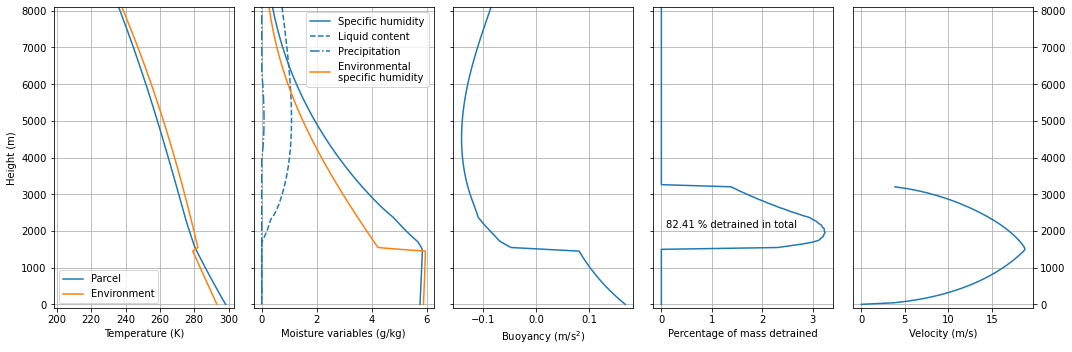

In [86]:
plot_updraft(updraft)

## Descending thermals

The `downdraft` method of the `ThermalGenerator` object calculates all the relevant properties associated with the downdraft, and takes about 0.4 s:

In [54]:
generator.downdraft?

Signature:
generator.downdraft(
    i_init,
    delta_Q,
    w_initial,
    entrainment_rate,
    dnu_db,
    drag,
)
Docstring:
Calculate the properties associated with a descending thermal.

The descent is assumed to be triggered by the evaporation of
precipitation into an environmental parcel.

Args:
    i_init: Index of the initiation level.
    delta_Q: Total mass of liquid water initially evaporated
        into the environmental parcel at i_init.
    w_initial: Initial velocity (must be non-negative).
    entrainment_rate: Entrainment rate (should have dimensions
        of 1/length).
    dnu_db: The proportionality constant defining the detrainent
        rate nu. When the buoyancy b is negative, nu is zero,
        and when b > 0, nu = b*dnu_db. The dimensions of dnu_db
        should be time^2/length^2.
    drag: Drag coefficient for determining parcel velocity.
        Should have dimensions of 1/length.
    l_crit: The critical liquid water content above which
        preci

In [63]:
def plot_downdraft(downdraft):
    fig, axes = plt.subplots(1, 5, figsize=(15,5))

    axes[0].plot(downdraft.temperature, height, label='Parcel')
    axes[0].plot(temperature, height, label='Environment')
    axes[0].legend()
    axes[0].set(xlabel='Temperature (K)', ylabel='Height (m)')

    axes[1].plot(downdraft.specific_humidity*1e3, height,
                 label='Specific humidity')
    axes[1].plot(downdraft.liquid_content*1e3, height, '--', color='tab:blue',
                 label='Liquid content')
    axes[1].plot(specific_humidity*1e3, height,
                 label='Environmental\nspecific humidity')
    axes[1].legend()
    axes[1].set(xlabel='Moisture variables (g/kg)', ylabel='')

    axes[2].plot(downdraft.buoyancy, height)
    axes[2].set(xlabel='Buoyancy (m/s$^2$)', ylabel='')

    axes[3].plot(downdraft.m_detrained*1e2, height)
    axes[3].set(xlabel='Percentage of mass detrained', ylabel='')
    axes[3].text(
        0.1, 2500,
        '{:.2f} % detrained in total'.format(np.sum(downdraft.m_detrained.m)*1e2))

    axes[4].plot(downdraft.velocity, height)
    axes[4].set(xlabel='Velocity (m/s)', ylabel='')
    axes[4].yaxis.tick_right()

    for ax in axes:
        ax.grid()
        ax.set_ylim(-100, 5100)

    for ax in axes[1:-1]:
        ax.set_yticklabels([])

    fig.tight_layout()

In [80]:
%%time
i_init = np.searchsorted(pressure, env.pressure(5*units.km))
delta_Q = 5e-3*units.dimensionless
w_initial = 0*units.meter/units.second
rate = 0.5/units.km
dnu_db = 1e-2*units.second**2/units.meter**2
drag = 0/units.km
l_crit = 1e-3*units.dimensionless

downdraft = generator.downdraft(i_init, delta_Q, w_initial, rate, dnu_db, drag)

CPU times: user 264 ms, sys: 3.41 ms, total: 267 ms
Wall time: 267 ms


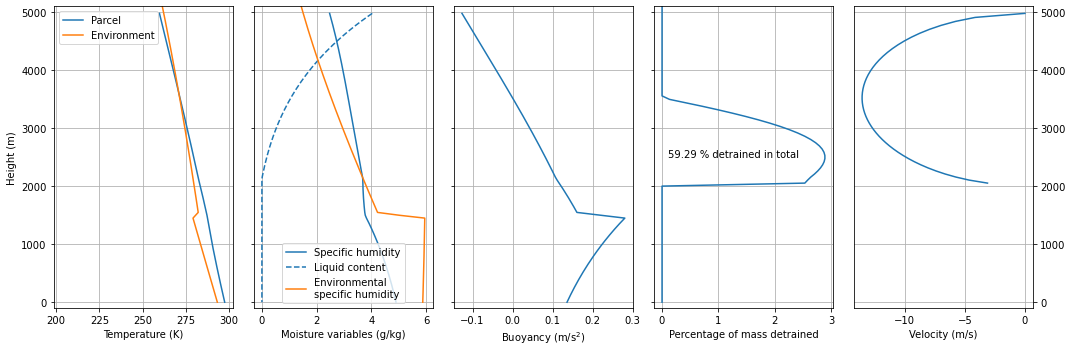

In [81]:
plot_downdraft(downdraft)

## Questions
- Does the two-way mixing have a similar effect on the environment as bulk detrainment, and does this need to be accounted for, i.e. `nu_total = eps + nu_bulk`?
    - Yes
- Does the assumption that rain water is well mixed in a descending thermal (see notes) mean that rain water is distributed to the dry environmental components that are entrained into the thermal?
    - Implementing this could solve the problem we saw last week with liquid evaporating too slowly because the components of the heterogeneous parcel do not mix
    - Would slow down the calculation significantly as the transfer matrices for environmental parcels would no longer be valid
- If precipitation forms when `q_c > q_crit`, how much of the liquid precipitates out: all of it or just `q_c - q_crit`?
    - The latter
- Should the re-evaporation of condensed water that detrains out of a downdraft (see notes) create new downdrafts?
    - No
- What does point 4 in the maths/coding section of the notes mean?

## Next steps
- Think about properties of mixed detrained air?
- Test updrafts/downdrafts in other soundings and different i_init